In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_log_error

from catboost import CatBoostRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('train.csv', index_col='id')
print('Rows:', df.shape[0], '\nColumns', df.shape[1])

Rows: 30471 
Columns 291


In [3]:
df.head()

,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,...,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,9,4,0,13,22,1,0,52,4,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,15,3,0,15,29,1,10,66,14,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,10,3,0,11,27,0,4,67,10,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,NaN,...,11,2,1,4,4,0,0,26,3,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,...,319,108,17,135,236,2,91,195,14,16331452


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30471 entries, 1 to 30473
Columns: 291 entries, timestamp to price_doc
dtypes: float64(119), int64(156), object(16)
memory usage: 67.9+ MB


In [5]:
train, test = train_test_split(df, test_size=0.2, random_state=42)

In [6]:
X_train = train.drop(['price_doc', 'timestamp'], axis=1)
y_train = train['price_doc']
X_test = test.drop(['price_doc', 'timestamp'], axis=1)
y_test = test['price_doc']

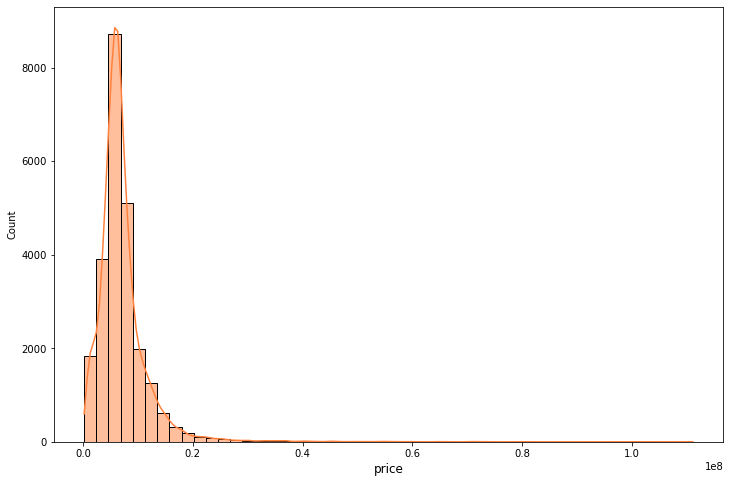

In [7]:
plt.figure(figsize=(12,8))
sns.histplot(train['price_doc'].values, bins=50, kde=True, color='#ff813d')
plt.xlabel('price', fontsize=12)
plt.show()

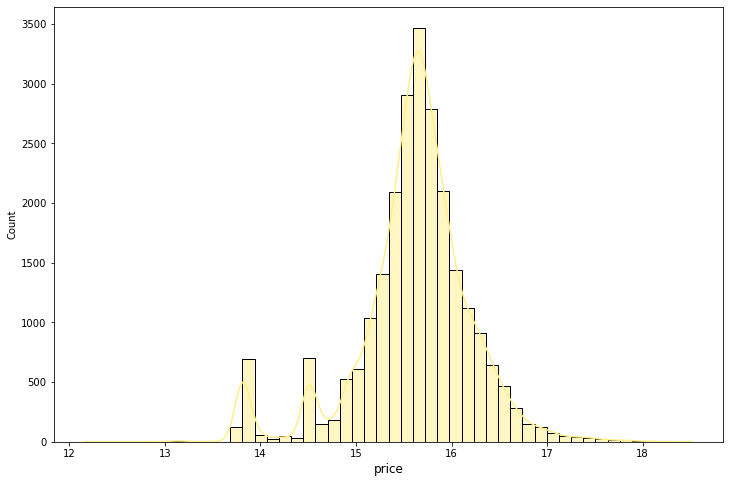

In [8]:
plt.figure(figsize=(12,8))
sns.histplot(np.log(train['price_doc'].values), bins=50, kde=True, color='#ffef8a')
plt.xlabel('price', fontsize=12)
plt.show()

In [9]:
cat_features = list(X_train.select_dtypes(include=['object']).columns)
df[cat_features]

,product_type,sub_area,culture_objects_top_25,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,water_1line,big_road1_1line,railroad_1line,ecology
id,,,,,,,,,,,,,,,
1,Investment,Bibirevo,no,no,no,no,no,no,no,no,no,no,no,no,good
2,Investment,Nagatinskij Zaton,yes,no,no,no,no,no,no,no,no,no,no,no,excellent
3,Investment,Tekstil'shhiki,no,no,no,no,yes,no,no,no,no,no,no,no,poor
4,Investment,Mitino,no,no,no,no,no,no,no,no,no,no,no,no,good
5,Investment,Basmannoe,no,no,no,no,yes,yes,no,no,no,no,no,yes,excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30469,Investment,Otradnoe,no,no,yes,no,yes,no,no,no,no,no,no,no,good
30470,Investment,Tverskoe,yes,no,no,no,yes,yes,no,no,yes,no,no,no,poor
30471,OwnerOccupier,Poselenie Vnukovskoe,no,no,no,no,no,no,no,no,no,no,no,no,no data


In [10]:
df['product_type'].value_counts()

Investment       19448
OwnerOccupier    11023
Name: product_type, dtype: int64

In [11]:
clf = CatBoostRegressor(iterations=100, verbose=0)

In [12]:
clf.fit(X_train, y_train, cat_features=cat_features)

In [13]:
mean_squared_log_error(clf.predict(X_train), y_train)

0.20082116457362686

In [14]:
mean_squared_log_error(clf.predict(X_test), y_test)

0.21802379909033384

In [15]:
def plot_feature_importance(importance, names, model_type, top=None):

#Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data=pd.DataFrame({'feature_names':feature_names,
                       'feature_importance':feature_importance})
    data.sort_values('feature_importance', ascending=False, inplace=True)
    if top:
        data = data[:top]

    plt.figure(figsize=(12,10))
    #Plot Searborn bar chart
    sns.barplot(x=data['feature_importance'], y=data['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    return list(data['feature_names'])

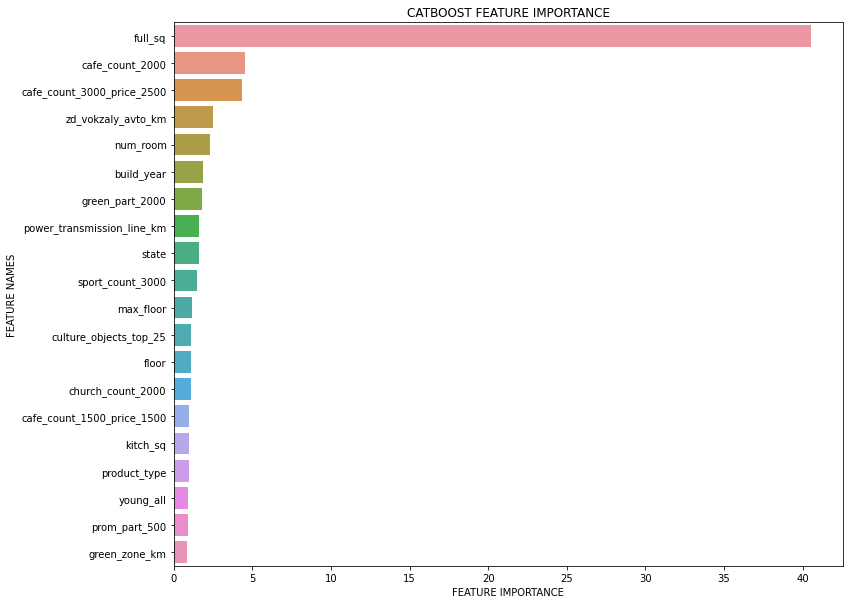

In [16]:
mif = plot_feature_importance(clf.get_feature_importance(), X_train.columns, 'CATBOOST', top=20)

In [17]:
X_train.select_dtypes([np.number]).columns

Index(['full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year',
       'num_room', 'kitch_sq', 'state', 'area_m',
       ...
       'cafe_count_5000_price_1500', 'cafe_count_5000_price_2500',
       'cafe_count_5000_price_4000', 'cafe_count_5000_price_high',
       'big_church_count_5000', 'church_count_5000', 'mosque_count_5000',
       'leisure_count_5000', 'sport_count_5000', 'market_count_5000'],
      dtype='object', length=274)

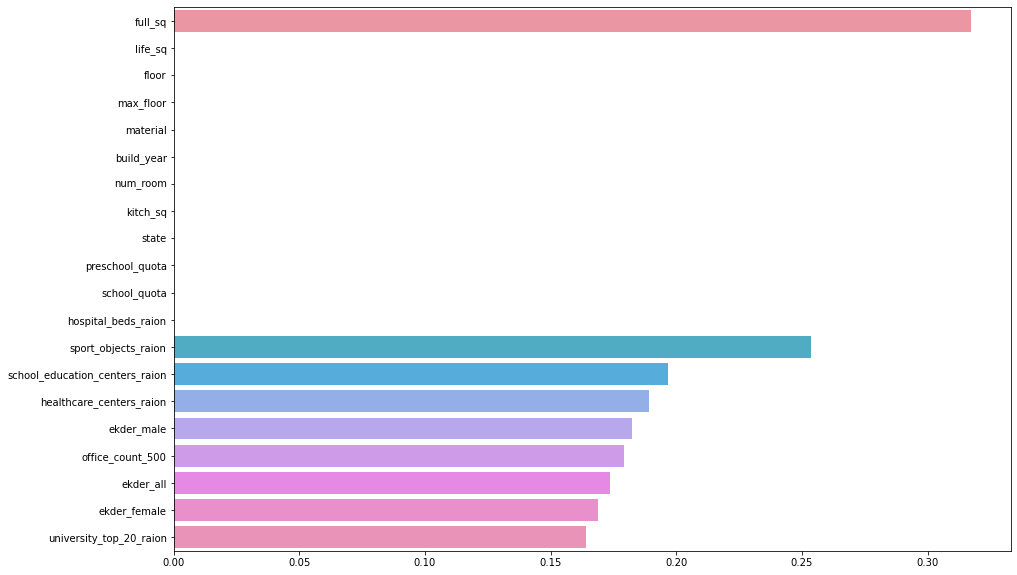

In [18]:
numeric_data = X_train.select_dtypes([np.number])
numeric_features = numeric_data.columns

correlations = {
    feature: np.corrcoef(X_train[feature], y_train)[0][1]
    for feature in numeric_features
}

sorted_correlations = sorted(correlations.items(), key=lambda x: x[1], reverse=True)
sorted_correlations = sorted_correlations[:20]
features_order = [x[0] for x in sorted_correlations]
correlations = [x[1] for x in sorted_correlations]

plot = sns.barplot(y=features_order, x=correlations)
plot.figure.set_size_inches(15, 10)

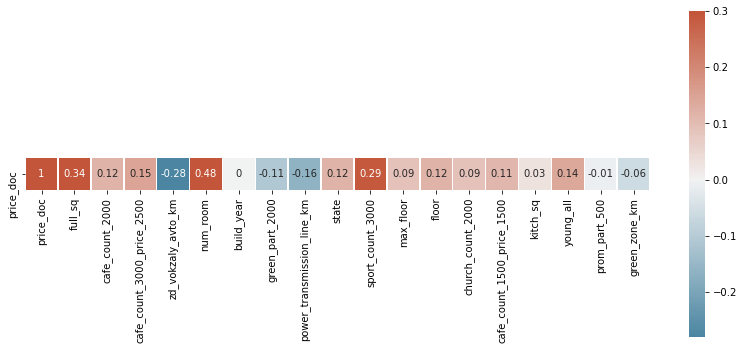

In [19]:
if not 'price_doc' in mif:
    mif.insert(0, 'price_doc')
f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
out = sns.heatmap(df[mif].corr().apply(lambda x : round(x, 2))[:1], cmap=cmap, 
                  vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

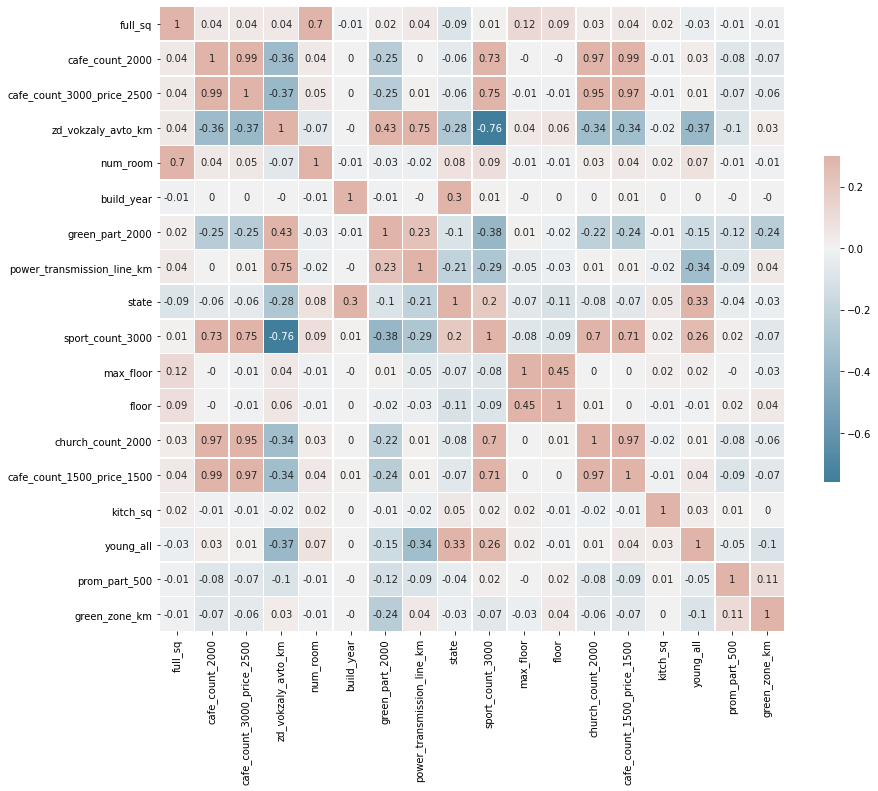

In [20]:
if 'price_doc' in mif:
    mif = mif[1:]
f, ax = plt.subplots(figsize=(14, 12))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
out = sns.heatmap(df[mif].corr().apply(lambda x : round(x, 2)), cmap=cmap, 
                  vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

### Для kaggle

In [21]:
sub = pd.read_csv('test.csv', index_col='id').drop(['timestamp'], axis=1)
sub['product_type'].fillna('Missing', inplace=True)
sub.head()

,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,...,cafe_count_5000_price_1500,cafe_count_5000_price_2500,cafe_count_5000_price_4000,cafe_count_5000_price_high,big_church_count_5000,church_count_5000,mosque_count_5000,leisure_count_5000,sport_count_5000,market_count_5000
id,,,,,,,,,,,,,,,,,,,,,
30474,39.0,20.7,2,9,1,1998.0,1,8.9,3.0,Investment,...,8,0,0,0,1,10,1,0,14,1
30475,79.2,NaN,8,17,1,0.0,3,1.0,1.0,OwnerOccupier,...,4,1,1,0,2,11,0,1,12,1
30476,40.5,25.1,3,5,2,1960.0,2,4.8,2.0,Investment,...,42,11,4,0,10,21,0,10,71,11
30477,62.8,36.0,17,17,1,2016.0,2,62.8,3.0,OwnerOccupier,...,1,1,2,0,0,10,0,0,2,0
30478,40.0,40.0,17,17,1,0.0,1,1.0,1.0,OwnerOccupier,...,5,1,1,0,2,12,0,1,11,1


In [22]:
sub['price_doc'] = clf.predict(sub)

In [23]:
submission = pd.DataFrame(sub['price_doc'])
submission.to_csv('submission.csv')

In [26]:
import pandas as pd
from catboost import CatBoostRegressor
df = pd.read_csv('train.csv', index_col='id')
X = df.drop(['price_doc', 'timestamp'], axis=1)
y = df['price_doc']
cat_features = list(X.select_dtypes(include=['object']).columns)
clf = CatBoostRegressor(iterations=100, verbose=0)
clf.fit(X, y, cat_features=cat_features)
df['price_pred'] = clf.predict(X)

data = df[[
    'sub_area',
    'timestamp',
    'full_sq',
    'life_sq',
    'floor',
    'max_floor',
    'material',
    'build_year',
    'num_room',
    'kitch_sq',
    'state',
    'product_type',
    'metro_km_walk',
    'kremlin_km',
    'price_doc',
    'price_pred'
]]
data = data.dropna()
data = data[(data['price_pred'] < 1.01 * data['price_doc']) 
            & (data['price_pred'] > 0.99 * data['price_doc'])
            & (data['build_year'] > 1900)
            & (data['num_room'] > 0)
            & (data['num_room'] < 10)
            & (data['max_floor'] > 0)
            & (data['max_floor'] < 50)
           ]
data = data.sample(500)
# del data['sub_area']
# del data['timestamp']
del data['price_pred']
# del data['price_doc']
data.to_csv('data_test_clean.csv')

In [27]:
data

,sub_area,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,metro_km_walk,kremlin_km,price_doc
id,,,,,,,,,,,,,,,
21121,Severnoe Tushino,2014-07-28,33,19.0,9.0,9.0,1.0,1968.0,1.0,6.0,2.0,Investment,1.357884,15.845849,5500000
21995,Severnoe Butovo,2014-08-28,38,19.0,5.0,17.0,1.0,1990.0,1.0,8.0,2.0,Investment,1.327595,20.389760,6150000
17166,Izmajlovo,2014-04-09,76,59.0,2.0,5.0,2.0,1954.0,3.0,4.0,3.0,Investment,0.697208,11.471116,10600000
11353,Nekrasovka,2013-10-18,63,60.0,2.0,17.0,1.0,2015.0,2.0,12.0,1.0,OwnerOccupier,3.776836,20.549464,6008354
28893,Zapadnoe Degunino,2015-04-05,35,19.0,11.0,12.0,5.0,1967.0,1.0,9.0,3.0,Investment,1.251811,13.409870,6150000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18192,Preobrazhenskoe,2014-05-06,42,26.0,3.0,5.0,1.0,1962.0,2.0,5.0,3.0,Investment,0.721855,8.250189,6800000
17872,Izmajlovo,2014-04-25,75,75.0,2.0,1.0,1.0,2014.0,2.0,1.0,1.0,OwnerOccupier,1.703934,10.288300,13615630
21589,Mitino,2014-08-18,80,80.0,15.0,15.0,1.0,2015.0,3.0,10.0,1.0,OwnerOccupier,0.695893,17.718526,11035006
